<a href="https://colab.research.google.com/github/Teja3993/Machine_Learning_Lab_Exercises/blob/main/ML_Lab_Exercise_Scalable_Data_Model_Parallelism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Task 1
!pip install torch torchvision

import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

#---Load Dataset---
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

#---Data Parallelism Example---

# Split dataset
train1, train2 = random_split(train_dataset, [30000, 30000])
loader1 = DataLoader(train1, batch_size=64, shuffle=True)
loader2 = DataLoader(train2, batch_size=64, shuffle=True)

# Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model = Net()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Helper function to compute gradients on one subset
def compute_gradients(data_loader):
    model.zero_grad()
    for data, target in data_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        break  # process only one batch per subset for simplicity
    grads = [p.grad.clone() for p in model.parameters()]
    return grads

# Training loop with gradient averaging
for epoch in range(2):
    grads1 = compute_gradients(loader1)
    grads2 = compute_gradients(loader2)

    # Average gradients
    with torch.no_grad():
        for p, g1, g2 in zip(model.parameters(), grads1, grads2):
            p.grad = (g1 + g2) / 2.0

    optimizer.step()
    print(f"Epoch {epoch+1} completed with averaged gradients.")


#---Model Parallelism Example---

# Define devices
device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device1 = torch.device("cuda:1" if torch.cuda.device_count() > 1 else device0)

# Split model across two devices
class SplitNet(nn.Module):
    def __init__(self):
        super(SplitNet, self).__init__()
        self.part1 = nn.Linear(28*28, 256).to(device0)
        self.part2 = nn.Linear(256, 10).to(device1)

    def forward(self, x):
        x = x.view(-1, 28*28).to(device0)
        x = F.relu(self.part1(x))
        x = x.to(device1)
        return self.part2(x)

# Initialize model, loss, and optimizer
model = SplitNet()
criterion = nn.CrossEntropyLoss().to(device1)
optimizer = optim.Adam([
    {'params': model.part1.parameters()},
    {'params': model.part2.parameters()}
], lr=0.001)

# One-batch demonstration
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
data, target = next(iter(train_loader))
data, target = data.to(device0), target.to(device1)

optimizer.zero_grad()
output = model(data)
loss = criterion(output, target)
loss.backward()
optimizer.step()

print("Model parallelism step completed successfully.")



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 504kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.31MB/s]


Epoch 1 completed with averaged gradients.
Epoch 2 completed with averaged gradients.
Model parallelism step completed successfully.


In [2]:
#Using Fashion-MNIST dataset
!pip install torch torchvision

import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import time

# Load Fashion-MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True,
                                      transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False,
                                     transform=transform, download=True)

print(f"✅ Training samples: {len(train_dataset)}")
print(f"✅ Test samples: {len(test_dataset)}")
print(f"✅ Classes: {train_dataset.classes}")

# Split dataset into two subsets
train1, train2 = random_split(train_dataset, [30000, 30000])
loader1 = DataLoader(train1, batch_size=64, shuffle=True)
loader2 = DataLoader(train2, batch_size=64, shuffle=True)

# Define simple model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Compute gradients for one subset
def compute_gradients(data_loader):
    model.zero_grad()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        total_loss += loss.item()
        break  # only one batch for demo speed
    grads = [p.grad.clone() for p in model.parameters()]
    return grads, total_loss

print("🚀 Starting Data Parallelism training...\n")
for epoch in range(2):
    start = time.time()
    grads1, loss1 = compute_gradients(loader1)
    grads2, loss2 = compute_gradients(loader2)

    # Average gradients
    with torch.no_grad():
        for p, g1, g2 in zip(model.parameters(), grads1, grads2):
            p.grad = (g1 + g2) / 2.0
    optimizer.step()
    end = time.time()

    print(f"Epoch {epoch+1}: Avg Loss = {(loss1 + loss2)/2:.4f}, Time = {end-start:.2f}s")

print("\n✅ Data Parallelism training completed successfully!")


# Define devices (simulate 2 GPUs if not available)
device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device1 = torch.device("cuda:1" if torch.cuda.device_count() > 1 else device0)

# Split model
class SplitNet(nn.Module):
    def __init__(self):
        super(SplitNet, self).__init__()
        self.part1 = nn.Linear(28*28, 256).to(device0)
        self.part2 = nn.Linear(256, 10).to(device1)
    def forward(self, x):
        x = x.view(-1, 28*28).to(device0)
        x = F.relu(self.part1(x))
        x = x.to(device1)
        return self.part2(x)

model = SplitNet()
criterion = nn.CrossEntropyLoss().to(device1)
optimizer = optim.Adam([
    {'params': model.part1.parameters()},
    {'params': model.part2.parameters()}
], lr=0.001)

# One batch demonstration
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
data, target = next(iter(train_loader))
data, target = data.to(device0), target.to(device1)

optimizer.zero_grad()
output = model(data)
loss = criterion(output, target)
loss.backward()
optimizer.step()

print(f"✅ Model parallelism step completed successfully.")
print(f"Loss from sample batch: {loss.item():.4f}")


100%|██████████| 26.4M/26.4M [00:01<00:00, 13.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.0MB/s]

✅ Training samples: 60000
✅ Test samples: 10000
✅ Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
🚀 Starting Data Parallelism training...

Epoch 1: Avg Loss = 2.3474, Time = 0.04s
Epoch 2: Avg Loss = 2.1110, Time = 0.03s

✅ Data Parallelism training completed successfully!
✅ Model parallelism step completed successfully.
Loss from sample batch: 2.2970


In [3]:

# Task 2
# Data Parallelism experiments



# Function to evaluate accuracy
def evaluate(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total


def run_data_parallel_experiment(num_splits):

    print(f"\n🚀 Running Data Parallelism with {num_splits} splits...")

    split_size = len(train_dataset) // num_splits
    subsets = random_split(train_dataset, [split_size] * num_splits)

    loaders = [DataLoader(subset, batch_size=64, shuffle=True) for subset in subsets]

    model_dp = Net().to(device)
    optimizer_dp = optim.Adam(model_dp.parameters(), lr=0.001)

    start = time.time()

    for epoch in range(2):
        grads_list = []
        for loader in loaders:
            model_dp.zero_grad()
            data, target = next(iter(loader))
            data, target = data.to(device), target.to(device)
            output = model_dp(data)
            loss = criterion(output, target)
            loss.backward()
            grads_list.append([p.grad.clone() for p in model_dp.parameters()])

        with torch.no_grad():
            for idx, p in enumerate(model_dp.parameters()):
                p.grad = sum(g[idx] for g in grads_list) / num_splits

        optimizer_dp.step()

    end = time.time()
    time_taken = end - start

    test_loader = DataLoader(test_dataset, batch_size=256)
    accuracy = evaluate(model_dp, test_loader, device)

    print(f"✅ Accuracy: {accuracy:.2f}% | Time: {time_taken:.3f} s")

    return [num_splits, accuracy, time_taken]


# Run for 2, 3, 4 splits
dp_results = []
for splits in [2, 3, 4]:
    dp_results.append(run_data_parallel_experiment(splits))

# Table
import pandas as pd
df_dp = pd.DataFrame(dp_results, columns=["Splits", "Accuracy (%)", "Training Time (s)"])
print("\n📊 DATA PARALLELISM RESULTS TABLE\n")
print(df_dp)



🚀 Running Data Parallelism with 2 splits...
✅ Accuracy: 39.28% | Time: 0.102 s

🚀 Running Data Parallelism with 3 splits...
✅ Accuracy: 37.87% | Time: 0.096 s

🚀 Running Data Parallelism with 4 splits...
✅ Accuracy: 50.90% | Time: 0.123 s

📊 DATA PARALLELISM RESULTS TABLE

   Splits  Accuracy (%)  Training Time (s)
0       2         39.28           0.101716
1       3         37.87           0.096439
2       4         50.90           0.123188


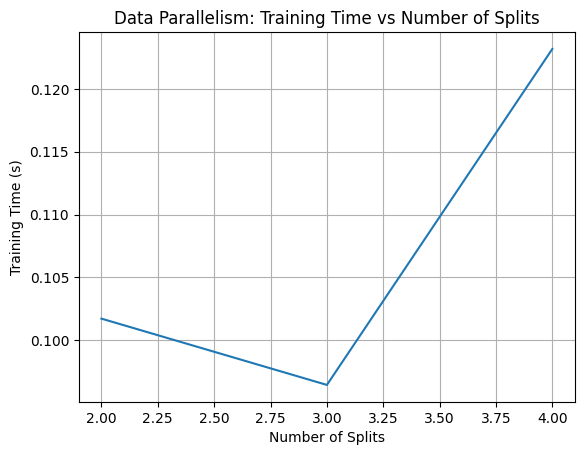

In [4]:

# PLot for Data Parallelism: Training time vs Splits


import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_dp["Splits"], df_dp["Training Time (s)"])
plt.xlabel("Number of Splits")
plt.ylabel("Training Time (s)")
plt.title("Data Parallelism: Training Time vs Number of Splits")
plt.grid(True)
plt.show()


In [5]:
#  Model parallelism experiments


def create_split_model(num_parts):
    layers = nn.ModuleList([
        nn.Linear(28*28, 256),
        nn.Linear(256, 128),
        nn.Linear(128, 64),
        nn.Linear(64, 10),
    ])

    layers = layers[:num_parts]   # Use only required number of parts

    parts = []
    for i, layer in enumerate(layers):
        dev = device0 if (i % 2 == 0) else device1
        parts.append(layer.to(dev))

    return layers, parts


def run_model_parallel_experiment(num_parts):

    print(f"\n🚀 Running Model Parallelism with {num_parts} parts...")

    layers, parts = create_split_model(num_parts)

    criterion_mp = nn.CrossEntropyLoss().to(device1)
    optimizer_mp = optim.Adam([{"params": l.parameters()} for l in layers], lr=0.001)

    start = time.time()

    for epoch in range(2):
        data, target = next(iter(DataLoader(train_dataset, batch_size=64)))
        x = data.view(-1, 28*28)

        # Forward across layers
        for i, layer in enumerate(layers):
            dev = device0 if (i % 2 == 0) else device1
            x = x.to(dev)
            target = target.to(device1)
            x = F.relu(layer(x)) if i < num_parts - 1 else layer(x)

        loss = criterion_mp(x, target)
        optimizer_mp.zero_grad()
        loss.backward()
        optimizer_mp.step()

    end = time.time()
    time_taken = end - start

    # Evaluate on test data
    correct, total = 0, 0
    for data, target in DataLoader(test_dataset, batch_size=256):
        x = data.view(-1, 28*28)
        for i, layer in enumerate(layers):
            dev = device0 if (i % 2 == 0) else device1
            x = x.to(dev)
            target = target.to(device1)
            x = F.relu(layer(x)) if i < num_parts - 1 else layer(x)
        _, predicted = torch.max(x, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    print(f"✅ Accuracy: {accuracy:.2f}% | Time: {time_taken:.3f} s")

    return [num_parts, accuracy, time_taken]


mp_results = []
for parts in [2, 3, 4]:
    mp_results.append(run_model_parallel_experiment(parts))

df_mp = pd.DataFrame(mp_results, columns=["Parts", "Accuracy (%)", "Training Time (s)"])
print("\n📊 MODEL PARALLELISM RESULTS TABLE\n")
print(df_mp)



🚀 Running Model Parallelism with 2 parts...
✅ Accuracy: 26.83% | Time: 0.057 s

🚀 Running Model Parallelism with 3 parts...
✅ Accuracy: 28.16% | Time: 0.034 s

🚀 Running Model Parallelism with 4 parts...
✅ Accuracy: 22.52% | Time: 0.035 s

📊 MODEL PARALLELISM RESULTS TABLE

   Parts  Accuracy (%)  Training Time (s)
0      2         26.83           0.057179
1      3         28.16           0.033620
2      4         22.52           0.035265


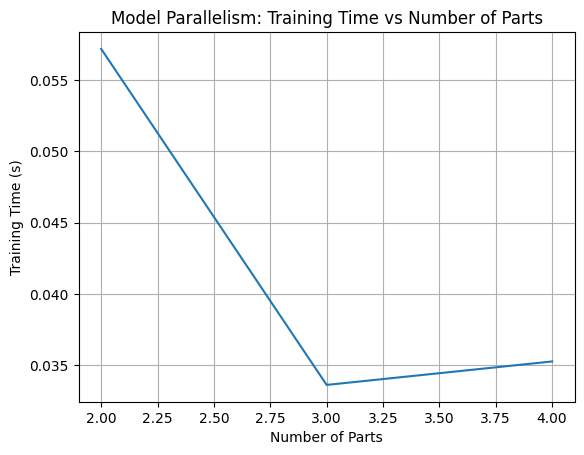

In [6]:

# PLOT — Model Parallelism Training Time vs Parts


plt.figure()
plt.plot(df_mp["Parts"], df_mp["Training Time (s)"])
plt.xlabel("Number of Parts")
plt.ylabel("Training Time (s)")
plt.title("Model Parallelism: Training Time vs Number of Parts")
plt.grid(True)
plt.show()
